In [1]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import linregress


# Merging Data & Exploratory Data Analysis


(168, 44)
             budget             id  popularity       revenue     runtime  \
count  1.680000e+02     168.000000  168.000000  1.680000e+02  168.000000   
mean   3.866718e+07   46640.863095   47.550017  1.869395e+08  114.136905   
std    5.576179e+07   80349.507764   60.685427  2.649249e+08   23.140789   
min    0.000000e+00      11.000000    0.335195  0.000000e+00   70.000000   
25%    2.675000e+06     902.000000   14.539569  1.459309e+07   97.000000   
50%    1.550000e+07   11176.500000   30.122312  7.103537e+07  110.000000   
75%    4.041942e+07   46447.000000   64.119329  2.228086e+08  124.000000   
max    2.550000e+08  354110.000000  481.098624  1.274219e+09  216.000000   

       vote_average    vote_count   Unnamed: 0         year  critic_score  \
count    168.000000    168.000000   168.000000   168.000000    168.000000   
mean       7.105357   1912.089286   759.589286  1996.220238     86.297619   
std        0.749871   2374.078516   554.867415    19.689635     19.110946 

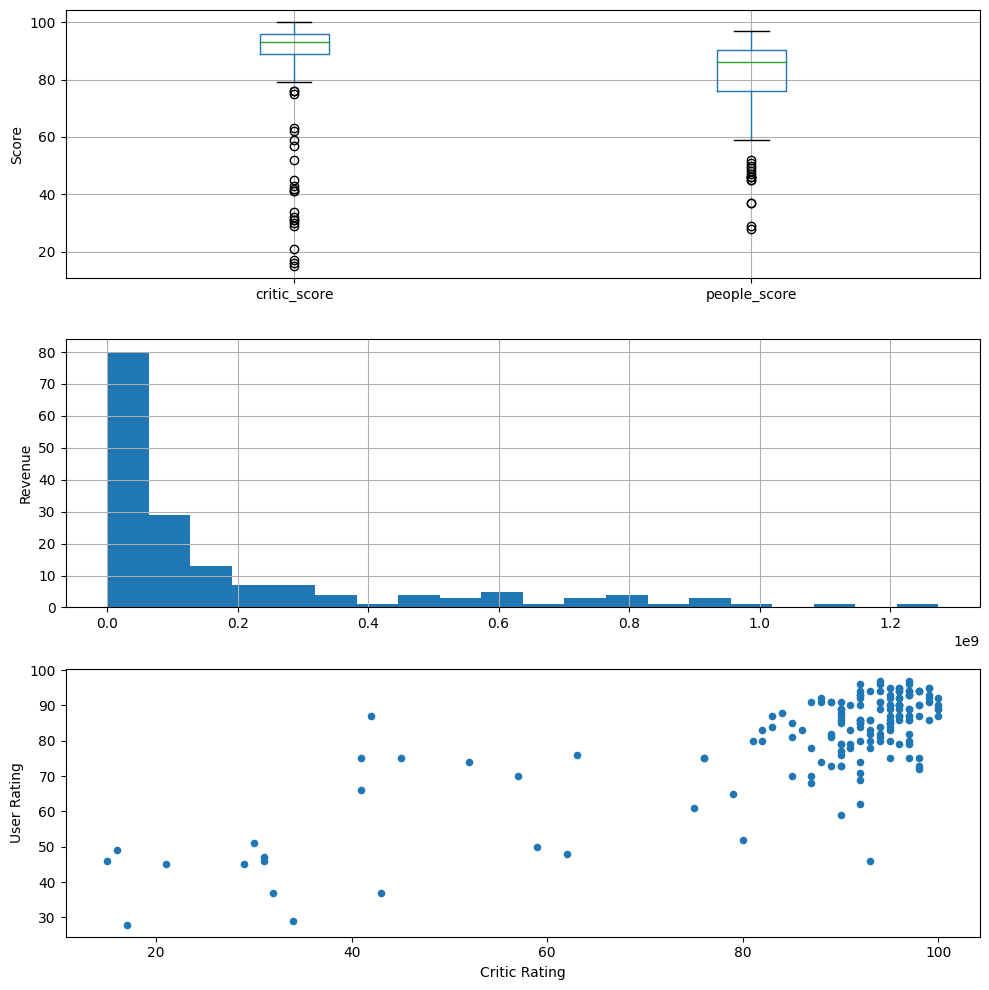

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# reading the data
data_tmdb = pd.read_csv("../data/tmdb_5000_movies.csv")
data_rt = pd.read_csv("../data/rotten_tomatoes_top_movies.csv")

# converting object column into numerical column for runtime
data_rt['hours'] = data_rt['runtime'].str.extract(
    '(\d+)h', expand=False).fillna(0).astype(float)
data_rt['minutes'] = data_rt['runtime'].str.extract(
    '(\d+)m', expand=False).fillna(0).astype(float)
data_rt['runtime'] = data_rt['hours'] * 60 + data_rt['minutes']
data_rt = data_rt.drop(['hours', 'minutes'], axis=1)

# removing duplicates in both datasets
data_tmdb = data_tmdb.drop_duplicates(subset='title')
data_rt = data_rt.drop_duplicates(subset='title')

# merging the data
movies = pd.merge(data_tmdb, data_rt, on=['title', 'runtime'], how='inner')

# exploratory data analysis
print(movies.shape)
# print(movies.dtypes)
print(movies.describe())

# handling missing data
# print(movies.isnull().sum())

# removing leading/trailing whitespace from column names
movies.columns = movies.columns.str.strip()

# removing unnecessary columns
movies = movies.drop(['homepage', 'consensus', 'link', 'status', 'release_date_(theaters)', 'original_language_x', 'spoken_languages', 'rating', 'tagline',
                     'original_language_y', 'producer', 'writer', 'director', 'release_date_(streaming)', 'production_co', 'sound_mix', 'aspect_ratio', 'view_the_collection'], axis=1)

# checking for abnormalities
abnormal_critic_scores = movies[(
    movies['critic_score'] > 100) | (movies['critic_score'] < 0)]
if not abnormal_critic_scores.empty:
    print("Abnormal values found in critic_score column:\n", abnormal_critic_scores)

abnormal_people_scores = movies[(
    movies['people_score'] > 100) | (movies['people_score'] < 0)]
if not abnormal_people_scores.empty:
    print("Abnormal values found in people_score column:\n", abnormal_people_scores)

# extracting year from the release date
movies['year'] = pd.to_datetime(movies['release_date']).dt.year

movies.to_csv("../data/movies.csv", index=False)

# some basic visualizations
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

# boxplot for critic_score and people_score
movies[['critic_score', 'people_score']].boxplot(ax=axes[0])
axes[0].set_ylabel('Score')

# histogram of movie revenue
movies['revenue'].hist(ax=axes[1], bins=20)
axes[1].set_ylabel('Revenue')

# scatter plot of critic_score vs people_score
movies.plot.scatter(x='critic_score', y='people_score', ax=axes[2])
axes[2].set_xlabel('Critic Rating')
axes[2].set_ylabel('User Rating')

plt.tight_layout()

plt.show()


# OLS Regression Analysis for Hypothesis Testing


                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     6.601
Date:                Mon, 03 Apr 2023   Prob (F-statistic):             0.0111
Time:                        15:34:45   Log-Likelihood:                -3493.0
No. Observations:                 168   AIC:                             6990.
Df Residuals:                     166   BIC:                             6996.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -4.701e+07   9.33e+07     -0.504   

<AxesSubplot: >

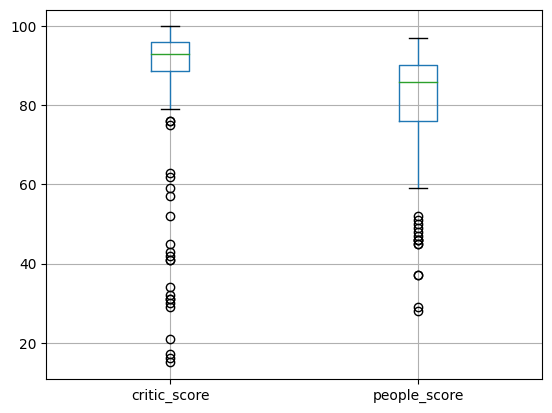

In [12]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score

np.random.seed(42)

# download data
movies = pd.read_csv("../data/movies.csv")

# perform ordinary least squares regression analysis
model = smf.ols('revenue ~ critic_score', data=movies).fit()
summary = model.summary()
print(summary)

# store information into a dataframe
results = {}
results['R-squared'] = model.rsquared
results['Prob (F-statistic)'] = model.f_pvalue
results['Coefficients'] = model.params.to_dict()
results['Standard errors'] = model.bse.to_dict()
results['t-values'] = model.tvalues.to_dict()
results['p-values'] = model.pvalues.to_dict()

results = pd.DataFrame(results)

# checking how much the variance describes the data
print(
    f"The variance explained by the linear regression model is {round(results['R-squared'][0] * 100, 2)}%\n")

# checking the p-value for hypothesis testing on intercept and coefficient of critic_score
alpha = 0.05
if results['Prob (F-statistic)'][0] > alpha:
    print(
        f"The p-value for the F-statistic is greater than {alpha}, so we cannot reject the null hypothesis.")
    print(f"Null hypothesis: There is no significant relationship between critic_score and revenue.\n")
else:
    print(
        f"The p-value for the F-statistic is less than or equal to {alpha}, so we can reject the null hypothesis.")
    print(f"Alternative hypothesis: There is a significant relationship between critic_score and revenue.\n")


# Hypothesis Testing Using ANOVA Against Various Columns


In [4]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

np.random.seed(42)

# load the dataset
movies = pd.read_csv('../data/movies.csv')

# specify the linear model formula
formula = 'revenue ~ C(genre)'
# formula = 'critic_score ~ C(genre)'

# fit the linear model using the specified formula
model = smf.ols(formula, movies).fit()

# calculate ANOVA table statistics
anova_table = sm.stats.anova_lm(model, type=2)

# perform hypothesis test using p-value from ANOVA table
alpha = 0.05
p_value = anova_table['PR(>F)'][0]

if p_value > alpha:
    print("Fail to reject the null hypothesis that the mean revenue is equal across different genres.")
else:
    print("Reject the null hypothesis that the mean revenue is equal across different genres.")

# display the ANOVA table
print(anova_table)


Reject the null hypothesis that the mean revenue is equal across different genres.
            df        sum_sq       mean_sq          F        PR(>F)
C(genre)  91.0  1.109732e+19  1.219486e+17  14.862014  1.681103e-26
Residual  76.0  6.236095e+17  8.205389e+15        NaN           NaN


# Creating Regression Analysis & Plots for Finding Relationships


This is testing year against critic_score
Slope: -0.2393360917353985
Intercept: 564.0708675548146
Correlation coefficient: -0.24696415712278305
P-value: 0.0012498129644588534
Standard error of the regression: 0.07288783208236882

This is testing year against people_score
Slope: -0.2058676368459776
Intercept: 492.05133036546823
Correlation coefficient: -0.28494205817674856
P-value: 0.0001813981862317859
Standard error of the regression: 0.05375141083293208

This is testing runtime against critic_score
Slope: 0.022276670359232816
Intercept: 83.75502884441495
Correlation coefficient: 0.02697405599751924
P-value: 0.728533789238226
Standard error of the regression: 0.06407548849884061

This is testing runtime against people_score
Slope: 0.12364097181560103
Intercept: 66.97728788949911
Correlation coefficient: 0.20081730380588464
P-value: 0.009051553191603334
Standard error of the regression: 0.04681324415855152

This is testing revenue against critic_score
Slope: 1.4107048820762123e-08
Inte

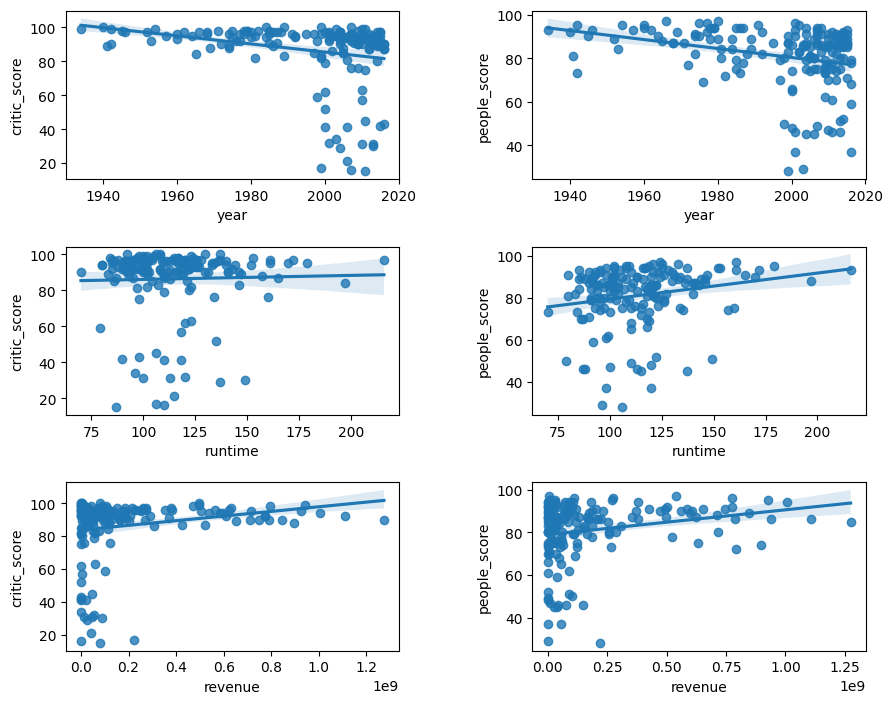

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# importing data
movies = pd.read_csv("../data/movies.csv")

f, axes = plt.subplots(3, 2, figsize=(10, 8))

# plotting each and every relevant relationship
sns.regplot(data=movies, x='year', y='critic_score', ax=axes[0, 0])
sns.regplot(data=movies, x='year', y='people_score', ax=axes[0, 1])
sns.regplot(data=movies, x='runtime', y='critic_score', ax=axes[1, 0])
sns.regplot(data=movies, x='runtime', y='people_score', ax=axes[1, 1])
sns.regplot(data=movies, x='revenue', y='critic_score', ax=axes[2, 0])
sns.regplot(data=movies, x='revenue', y='people_score', ax=axes[2, 1])

iv = ['year', 'runtime', 'revenue']
dv = ['critic_score', 'people_score']

# loop through iv and dv to print regression results
for i, ivar in enumerate(iv):
    for j, dvar in enumerate(dv):
        slope, intercept, rvalue, pvalue, stderr = linregress(
            movies[ivar], movies[dvar])
        print(f"This is testing {ivar} against {dvar}")
        print(f"Slope: {slope}")
        print(f"Intercept: {intercept}")
        print(f"Correlation coefficient: {rvalue}")
        print(f"P-value: {pvalue}")
        print(f"Standard error of the regression: {stderr}\n")

# adjust the spacing between the subplots
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9,
                    top=0.9, wspace=0.4, hspace=0.4)

plt.show()


# JointGrid Plot for Critic Scores vs. Revenue


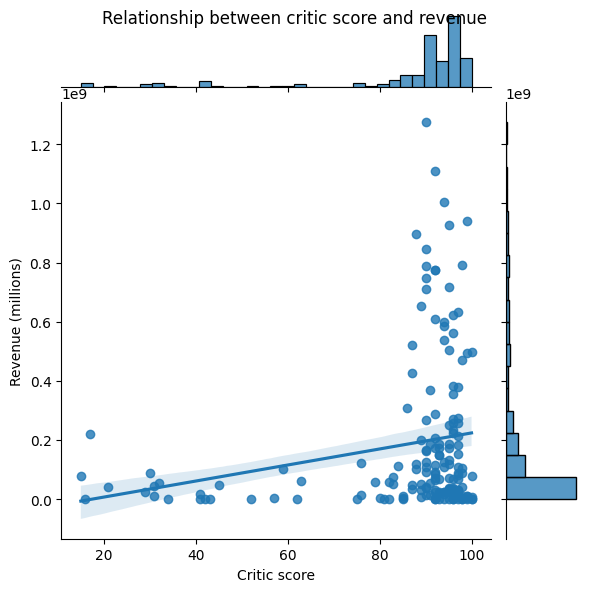

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# importing data
movies = pd.read_csv("../data/movies.csv")

# create jointgrid plot
g = sns.JointGrid(data=movies, x="critic_score", y="revenue")

# add regplot
sns.regplot(x="critic_score", y="revenue", data=movies, ax=g.ax_joint)

# add histplot
sns.histplot(x="critic_score", data=movies, ax=g.ax_marg_x, kde=False)
sns.histplot(y="revenue", data=movies, ax=g.ax_marg_y, kde=False)

# set title and axis labels
g.set_axis_labels("Critic score", "Revenue (millions)")
g.fig.suptitle("Relationship between critic score and revenue")

# show plot
plt.show()
